In [1]:
%tensorflow_version 1.x
!pip install adversarial-robustness-toolbox
!git clone https://github.com/tensorflow/cleverhans.git
!pip install cleverhans/
!pip install cma

TensorFlow 1.x selected.
     |████████████████████████████████| 491kB 16.7MB/s 
     |████████████████████████████████| 7.1MB 13.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Cloning into 'cleverhans'...
remote: Enumerating objects: 13501, done.
remote: Total 13501 (delta 0), reused 0 (delta 0), pack-reused 13501
Receiving objects: 100% (13501/13501), 8.40 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (9494/9494), done.
Processing ./cleverhans
     |████████████████████████████████| 163kB 36.9MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=253453 sha256=05e636b5afd6ecc900edb8b49f5bd153da076f022d68586f54a510179c9348ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-aasy0jnh/wheels/d1/6b/1d/5cf7b3ca4c0cfc7f845628b8ed46366ab5f4f56b5483e9db7f
Successfully built cleverhans
    

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
import numpy as np
import matplotlib.pyplot as plt
from art.attacks import ZooAttack
from art.classifiers import KerasClassifier
from art.utils import load_dataset
import random
import tensorflow as tf
import tensorflow_hub as hub
tf.compat.v1.disable_eager_execution()



# Step 1: Load the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10")) # Original Dataset
print("x_train shape: " + str(x_train.shape) + "\n" + "x_train size: " + str(x_train.size) + "\n" + # this print statement is used for understanding what the CIFAR-10 dataset is
      "y_train shape: " + str(y_train.shape) + "\n" + "y_train size: " + str(y_train.size) + "\n" +
      "x_test shape: " + str(x_test.shape) + "\n" + "x_test size: " + str(x_test.size) + "\n" +
      "y_test shape: " + str(y_test.shape) + "\n" + "y_test size: " + str(y_test.size) + "\n")
print()



# Step 2: Load the victim model
classifier_url ="https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1" #@param {type:"string"} # model is downloaded from this site
IMAGE_SHAPE = (32, 32) # the image shape is needed so that the model knows the input-shape and since we are working with the CIFAR-10 all the images are 32 x 32 color images
classifier = KerasClassifier(model=tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))]), clip_values=(min_, max_)) # this bascially creates a keras wrapper around the downloaded model so that we can use it with keras functions.



# Step 3: Evaluate the victim model on the benign dataset
predictions = classifier.predict(x_test) # giving the classifier the x_test of the CIFAR-10 dataset.
accuracy_benign = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test) # calculates the accuracy of the predictions
print("Accuracy on benign test examples: {}%\n".format(accuracy_benign * 100))



# Step 4: Collect 10 instances of each class from test set
def exract_ten_classes(data, labels, classes=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), no_instance=10):
    x_pre = []  # list to collect the x_test set
    y_pre = []  # list to collect the y_test set
    for class_label in range(0, 10):  # loop through each of the classes
        index = random.randint(0, 5000)  # choose an index from the x_test
        iteration = no_instance  # number of instance of each class to collect
        while (iteration != 0):
            if np.argmax(labels[index]) == classes[class_label]:  # check if the current index label matches the specified class label we are looking for
                x_pre.append(data[index])  # add the image to the x_test set
                y_pre.append(int(class_label))  # add the image label to the y_test set
                iteration = iteration - 1  # reduce # of instances by 1
            index = index + 1  # go to next index till next label is of the current class
    x = np.asarray(x_pre)  # append all 100, 10 of each class, images together
    y = keras.utils.to_categorical(np.asarray(y_pre), 10)  # append all 100, 10 of each class, labels together and do one hot encoding
    return x, y

x_test_adv_pre, y_test_adv = exract_ten_classes( x_test, y_test )
print("x_test_adv_pre shape: " + str(x_test_adv_pre.shape) + "\n" + "x_test_adv_pre size: " + str(x_test_adv_pre.size) + "\n" +
      "y_test_adv_pre shape: " + str(y_test_adv.shape) + "\n" + "y_test_adv_pre size: " + str(y_test_adv.size) + "\n")


# Step 6: Generate adversarial test examples and Evaluate the ART classifier on adversarial test examples
attack_eps_5 = ZooAttack(classifier=classifier)
x_test_adv_eps_5 = attack_eps_5.generate(x=x_test_adv_pre)
predictions_eps_5 = classifier.predict(x_test_adv_eps_5)
accuracy_adv_eps_5 = np.sum(np.argmax(predictions_eps_5, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
#print("Accuracy on adversarial test examples with max_iter = 20: {}%".format(accuracy_adv_eps_5 * 100))

attack_eps_10 = ZooAttack(classifier=classifier, max_iter=40)
x_test_adv_eps_10 = attack_eps_10.generate(x=x_test_adv_pre)
predictions_eps_10 = classifier.predict(x_test_adv_eps_10)
accuracy_adv_eps_10 = np.sum(np.argmax(predictions_eps_10, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
#print("Accuracy on adversarial test examples with max_iter = 20:: {}%".format(accuracy_adv_eps_10 * 100))

attack_eps_50 = ZooAttack(classifier=classifier,max_iter=70)
x_test_adv_eps_50 = attack_eps_50.generate(x=x_test_adv_pre)
predictions_eps_50 = classifier.predict(x_test_adv_eps_50)
accuracy_adv_eps_50 = np.sum(np.argmax(predictions_eps_50, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
#print("Accuracy on adversarial test examples with eps = 0.5: {}%".format(accuracy_adv_eps_50 * 100))

attack_eps_95 = ZooAttack(classifier=classifier, max_iter=100)
x_test_adv_eps_95 = attack_eps_95.generate(x=x_test_adv_pre)
predictions_eps_95 = classifier.predict(x_test_adv_eps_95)
accuracy_adv_eps_95 = np.sum(np.argmax(predictions_eps_95, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
#print("Accuracy on adversarial test examples with eps = 0.95: {}%".format(accuracy_adv_eps_95 * 100))

accuracies = [accuracy_adv_eps_5 * 100, accuracy_adv_eps_10 * 100, accuracy_adv_eps_50 * 100, accuracy_adv_eps_95 * 100]


# Step 7: Plot Results
for ind in range(0, 100, 5):
    fig = plt.figure(figsize=(16, 16))
    fig.suptitle('Adversarial Attack On Victim Model', fontsize=24, fontweight='bold')
    columns = 5
    rows = 7
    ax = []

    ax.append(fig.add_subplot(rows, columns, 1))
    plt.text(0.38, 0.1, 'Original Image', fontsize=10, fontweight='bold')
    plt.axis('off')

    eps = [20, 40, 70, 100]
    for i in range(2, 6):
        ax.append(fig.add_subplot(rows, columns, i))
        plt.text(0.0, 0.1, 'Adversarial Image Max_ITER = ' + str(eps[i - 2]), fontsize=10, fontweight='bold')
        plt.axis('off')

    imageindex = ind
    for i in range(5, columns*rows - 6, 5):
        sample_pre = x_test_adv_pre[ imageindex, :]
        ax.append( fig.add_subplot(rows, columns, i + 1) )
        label_pre = np.argmax(classifier.predict(sample_pre.reshape((1, sample_pre.shape[0], sample_pre.shape[1], sample_pre.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_pre))
        plt.imshow(sample_pre)

        sample_post_eps_5 = x_test_adv_eps_5[ imageindex, :]
        ax.append( fig.add_subplot(rows, columns, i + 2) )
        label_post_eps_5 = np.argmax(classifier.predict(sample_post_eps_5.reshape((1, sample_post_eps_5.shape[0], sample_post_eps_5.shape[1], sample_post_eps_5.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_5))
        plt.imshow(sample_post_eps_5)

        sample_post_eps_10 = x_test_adv_eps_10[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 3))
        label_post_eps_10 = np.argmax(classifier.predict(sample_post_eps_10.reshape((1, sample_post_eps_10.shape[0], sample_post_eps_10.shape[1], sample_post_eps_10.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_10))
        plt.imshow(sample_post_eps_10)

        sample_post_eps_50 = x_test_adv_eps_50[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 4))
        label_post_eps_50 = np.argmax(classifier.predict(sample_post_eps_50.reshape((1, sample_post_eps_50.shape[0], sample_post_eps_50.shape[1], sample_post_eps_50.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_50))
        plt.imshow(sample_post_eps_50)

        sample_post_eps_95 = x_test_adv_eps_95[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 5))
        label_post_eps_95 = np.argmax(classifier.predict(sample_post_eps_95.reshape((1, sample_post_eps_95.shape[0], sample_post_eps_95.shape[1], sample_post_eps_95.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_95))
        plt.imshow(sample_post_eps_95)

        imageindex = imageindex + 1


    ax.append(fig.add_subplot(rows, columns, 31))
    plt.text(0.0, 0.5, "Accuracy on benign test examples: {}%".format(round(accuracy_benign * 100),2), fontsize=8, fontweight='bold')
    plt.axis('off')

    for i in range(32, 36):
        ax.append(fig.add_subplot(rows, columns, i))
        plt.text(0.0, 0.5, "Accuracy on test examples eps = " + str(eps[i-32]) + ": {}%".format(round(accuracies[i-32]), 2), fontsize=8, fontweight='bold')
        plt.axis('off')

    fig.tight_layout(h_pad=4.0, w_pad=4.0)
    plt.show()


# Step 9: Data from Results
print()
print("Accuracy on benign test examples: {}%".format(accuracy_benign * 100))
print("Accuracy on adversarial test examples with max_iter = 20:: {}%".format(accuracies[0]))
print("Accuracy on adversarial test examples with max_iter = 40:: {}%".format(accuracies[1]))
print("Accuracy on adversarial test examples with max_iter = 70:: {}%".format(accuracies[2]))
print("Accuracy on adversarial test examples with max_iter = 100:: {}%".format(accuracies[3]))
print()

all_count = []
for j in range(0, 100, 10):
    count = [0, 0, 0, 0, 0]
    for i in range(j, j + 10):
        sample_pre = x_test_adv_pre[ i, : ]
        label_pre = np.argmax(classifier.predict(sample_pre.reshape((1, sample_pre.shape[0], sample_pre.shape[1], sample_pre.shape[2]))))
        sample_post_eps_5 = x_test_adv_eps_5[ i, : ]
        label_post_eps_5 = np.argmax(classifier.predict(sample_post_eps_5.reshape((1, sample_post_eps_5.shape[0], sample_post_eps_5.shape[1], sample_post_eps_5.shape[2]))))
        sample_post_eps_10 = x_test_adv_eps_10[ i, : ]
        label_post_eps_10 = np.argmax(classifier.predict(sample_post_eps_10.reshape((1, sample_post_eps_10.shape[0], sample_post_eps_10.shape[1], sample_post_eps_10.shape[2]))))
        sample_post_eps_50 = x_test_adv_eps_50[ i, : ]
        label_post_eps_50 = np.argmax(classifier.predict(sample_post_eps_50.reshape((1, sample_post_eps_50.shape[0], sample_post_eps_50.shape[1], sample_post_eps_50.shape[2]))))
        sample_post_eps_95 = x_test_adv_eps_95[ i, : ]
        label_post_eps_95 = np.argmax(classifier.predict(sample_post_eps_95.reshape((1, sample_post_eps_95.shape[0], sample_post_eps_95.shape[1], sample_post_eps_95.shape[2]))))
        if (label_pre == np.argmax(y_test_adv[i])):
            count[0] = count[0] + 1
        if (label_post_eps_5 == np.argmax(y_test_adv[i])):
            count[1] = count[1] + 1
        if (label_post_eps_10 == np.argmax(y_test_adv[i])):
            count[2] = count[2] + 1
        if (label_post_eps_50 == np.argmax(y_test_adv[i])):
            count[3] = count[3] + 1
        if (label_post_eps_95 == np.argmax(y_test_adv[i])):
            count[4] = count[4] + 1
    all_count.append(count)
print()

Labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
for i in range(0, 10):
    print("Classifier with benign example has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][0] / 10) * 100) + "%")
    print("Fast Gradient Method with max_iter = 20: has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][1] / 10) * 100) + "%")
    print("Fast Gradient Method with max_iter = 40: has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][2] / 10) * 100) + "%")
    print("Fast Gradient Method with max_iter = 70: has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][3] / 10) * 100) + "%")
    print("Fast Gradient Method with max_iter = 100: has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][4] / 10) * 100) + "%")
    print()

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
x_train size: 153600000
y_train shape: (50000, 10)
y_train size: 500000
x_test shape: (10000, 32, 32, 3)
x_test size: 30720000
y_test shape: (10000, 10)
y_test size: 100000


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Accuracy on benign test examples: 94.52000000000001%

x_test_adv_pre shape: (100, 32, 32, 3)
x_test_adv_pre size: 307200
y_test_adv_pre shape: (100, 10)
y_test_adv_pre size: 1000



In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
import numpy as np
import matplotlib.pyplot as plt
from art.attacks import ZooAttack
from art.classifiers import KerasClassifier
from art.utils import load_dataset
import random
import tensorflow as tf
import tensorflow_hub as hub
tf.compat.v1.disable_eager_execution()



# Step 1: Load the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10")) # Original Dataset
print("x_train shape: " + str(x_train.shape) + "\n" + "x_train size: " + str(x_train.size) + "\n" + # this print statement is used for understanding what the CIFAR-10 dataset is
      "y_train shape: " + str(y_train.shape) + "\n" + "y_train size: " + str(y_train.size) + "\n" +
      "x_test shape: " + str(x_test.shape) + "\n" + "x_test size: " + str(x_test.size) + "\n" +
      "y_test shape: " + str(y_test.shape) + "\n" + "y_test size: " + str(y_test.size) + "\n")
print()



# Step 2: Load the victim model
classifier_url ="https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1" #@param {type:"string"} # model is downloaded from this site
IMAGE_SHAPE = (32, 32) # the image shape is needed so that the model knows the input-shape and since we are working with the CIFAR-10 all the images are 32 x 32 color images
classifier = KerasClassifier(model=tf.keras.Sequential([hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))]), clip_values=(min_, max_)) # this bascially creates a keras wrapper around the downloaded model so that we can use it with keras functions.



# Step 3: Evaluate the victim model on the benign dataset
predictions = classifier.predict(x_test) # giving the classifier the x_test of the CIFAR-10 dataset.
accuracy_benign = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test) # calculates the accuracy of the predictions
print("Accuracy on benign test examples: {}%\n".format(accuracy_benign * 100))



# Step 4: Collect 10 instances of each class from test set
def exract_ten_classes(data, labels, classes=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), no_instance=10):
    x_pre = []  # list to collect the x_test set
    y_pre = []  # list to collect the y_test set
    for class_label in range(0, 10):  # loop through each of the classes
        index = random.randint(0, 5000)  # choose an index from the x_test
        iteration = no_instance  # number of instance of each class to collect
        while (iteration != 0):
            if np.argmax(labels[index]) == classes[class_label]:  # check if the current index label matches the specified class label we are looking for
                x_pre.append(data[index])  # add the image to the x_test set
                y_pre.append(int(class_label))  # add the image label to the y_test set
                iteration = iteration - 1  # reduce # of instances by 1
            index = index + 1  # go to next index till next label is of the current class
    x = np.asarray(x_pre)  # append all 100, 10 of each class, images together
    y = keras.utils.to_categorical(np.asarray(y_pre), 10)  # append all 100, 10 of each class, labels together and do one hot encoding
    return x, y

x_test_adv_pre, y_test_adv = exract_ten_classes( x_test, y_test )
print("x_test_adv_pre shape: " + str(x_test_adv_pre.shape) + "\n" + "x_test_adv_pre size: " + str(x_test_adv_pre.size) + "\n" +
      "y_test_adv_pre shape: " + str(y_test_adv.shape) + "\n" + "y_test_adv_pre size: " + str(y_test_adv.size) + "\n")


# Step 6: Generate adversarial test examples and Evaluate the ART classifier on adversarial test examples
attack_eps_5 = ZooAttack(classifier=classifier, max_iter=20)
x_test_adv_eps_5 = attack_eps_5.generate(x=x_test_adv_pre)
predictions_eps_5 = classifier.predict(x_test_adv_eps_5)
accuracy_adv_eps_5 = np.sum(np.argmax(predictions_eps_5, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
#print("Accuracy on adversarial test examples with eps = 0.05: {}%".format(accuracy_adv_eps_5 * 100))

attack_eps_10 = ZooAttack(classifier=classifier, max_iter=40)
x_test_adv_eps_10 = attack_eps_10.generate(x=x_test_adv_pre)
predictions_eps_10 = classifier.predict(x_test_adv_eps_10)
accuracy_adv_eps_10 = np.sum(np.argmax(predictions_eps_10, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
#print("Accuracy on adversarial test examples with eps = 0.1: {}%".format(accuracy_adv_eps_10 * 100))

attack_eps_50 = ZooAttack(classifier=classifier, max_iter=70)
x_test_adv_eps_50 = attack_eps_50.generate(x=x_test_adv_pre)
predictions_eps_50 = classifier.predict(x_test_adv_eps_50)
accuracy_adv_eps_50 = np.sum(np.argmax(predictions_eps_50, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
#print("Accuracy on adversarial test examples with eps = 0.5: {}%".format(accuracy_adv_eps_50 * 100))

attack_eps_95 = ZooAttack(classifier=classifier, max_iter=100)
x_test_adv_eps_95 = attack_eps_95.generate(x=x_test_adv_pre)
predictions_eps_95 = classifier.predict(x_test_adv_eps_95)
accuracy_adv_eps_95 = np.sum(np.argmax(predictions_eps_95, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv)
#print("Accuracy on adversarial test examples with eps = 0.95: {}%".format(accuracy_adv_eps_95 * 100))

accuracies = [accuracy_adv_eps_5 * 100, accuracy_adv_eps_10 * 100, accuracy_adv_eps_50 * 100, accuracy_adv_eps_95 * 100]


# Step 7: Plot Results
for ind in range(0, 100, 5):
    fig = plt.figure(figsize=(16, 16))
    fig.suptitle('Adversarial Attack On Victim Model', fontsize=24, fontweight='bold')
    columns = 5
    rows = 7
    ax = []

    ax.append(fig.add_subplot(rows, columns, 1))
    plt.text(0.38, 0.1, 'Original Image', fontsize=10, fontweight='bold')
    plt.axis('off')

    eps = [20, 40, 70, 100]
    for i in range(2, 6):
        ax.append(fig.add_subplot(rows, columns, i))
        plt.text(0.0, 0.1, 'Adversarial Image max_iter = ' + str(eps[i - 2]), fontsize=10, fontweight='bold')
        plt.axis('off')

    imageindex = ind
    for i in range(5, columns*rows - 6, 5):
        sample_pre = x_test_adv_pre[ imageindex, :]
        ax.append( fig.add_subplot(rows, columns, i + 1) )
        label_pre = np.argmax(classifier.predict(sample_pre.reshape((1, sample_pre.shape[0], sample_pre.shape[1], sample_pre.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_pre))
        plt.imshow(sample_pre)

        sample_post_eps_5 = x_test_adv_eps_5[ imageindex, :]
        ax.append( fig.add_subplot(rows, columns, i + 2) )
        label_post_eps_5 = np.argmax(classifier.predict(sample_post_eps_5.reshape((1, sample_post_eps_5.shape[0], sample_post_eps_5.shape[1], sample_post_eps_5.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_5))
        plt.imshow(sample_post_eps_5)

        sample_post_eps_10 = x_test_adv_eps_10[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 3))
        label_post_eps_10 = np.argmax(classifier.predict(sample_post_eps_10.reshape((1, sample_post_eps_10.shape[0], sample_post_eps_10.shape[1], sample_post_eps_10.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_10))
        plt.imshow(sample_post_eps_10)

        sample_post_eps_50 = x_test_adv_eps_50[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 4))
        label_post_eps_50 = np.argmax(classifier.predict(sample_post_eps_50.reshape((1, sample_post_eps_50.shape[0], sample_post_eps_50.shape[1], sample_post_eps_50.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_50))
        plt.imshow(sample_post_eps_50)

        sample_post_eps_95 = x_test_adv_eps_95[imageindex, :]
        ax.append(fig.add_subplot(rows, columns, i + 5))
        label_post_eps_95 = np.argmax(classifier.predict(sample_post_eps_95.reshape((1, sample_post_eps_95.shape[0], sample_post_eps_95.shape[1], sample_post_eps_95.shape[2]))))
        plt.text(33, 18, 'Data:\nTrue Label = %d\nPredicted Label = %d' % (np.argmax(y_test_adv[imageindex]), label_post_eps_95))
        plt.imshow(sample_post_eps_95)

        imageindex = imageindex + 1


    ax.append(fig.add_subplot(rows, columns, 31))
    plt.text(0.0, 0.5, "Accuracy on benign test examples: {}%".format(round(accuracy_benign * 100),2), fontsize=8, fontweight='bold')
    plt.axis('off')

    for i in range(32, 36):
        ax.append(fig.add_subplot(rows, columns, i))
        plt.text(0.0, 0.5, "Accuracy on test examples eps = " + str(eps[i-32]) + ": {}%".format(round(accuracies[i-32]), 2), fontsize=8, fontweight='bold')
        plt.axis('off')

    fig.tight_layout(h_pad=4.0, w_pad=4.0)
    plt.show()


# Step 9: Data from Results
print()
print("Accuracy on benign test examples: {}%".format(accuracy_benign * 100))
print("Accuracy on adversarial test examples with max_iter = 20: {}%".format(accuracies[0]))
print("Accuracy on adversarial test examples with max_iter = 40: {}%".format(accuracies[1]))
print("Accuracy on adversarial test examples with max_iter = 70: {}%".format(accuracies[2]))
print("Accuracy on adversarial test examples with max_iter = 100: {}%".format(accuracies[3]))
print()

all_count = []
for j in range(0, 100, 10):
    count = [0, 0, 0, 0, 0]
    for i in range(j, j + 10):
        sample_pre = x_test_adv_pre[ i, : ]
        label_pre = np.argmax(classifier.predict(sample_pre.reshape((1, sample_pre.shape[0], sample_pre.shape[1], sample_pre.shape[2]))))
        sample_post_eps_5 = x_test_adv_eps_5[ i, : ]
        label_post_eps_5 = np.argmax(classifier.predict(sample_post_eps_5.reshape((1, sample_post_eps_5.shape[0], sample_post_eps_5.shape[1], sample_post_eps_5.shape[2]))))
        sample_post_eps_10 = x_test_adv_eps_10[ i, : ]
        label_post_eps_10 = np.argmax(classifier.predict(sample_post_eps_10.reshape((1, sample_post_eps_10.shape[0], sample_post_eps_10.shape[1], sample_post_eps_10.shape[2]))))
        sample_post_eps_50 = x_test_adv_eps_50[ i, : ]
        label_post_eps_50 = np.argmax(classifier.predict(sample_post_eps_50.reshape((1, sample_post_eps_50.shape[0], sample_post_eps_50.shape[1], sample_post_eps_50.shape[2]))))
        sample_post_eps_95 = x_test_adv_eps_95[ i, : ]
        label_post_eps_95 = np.argmax(classifier.predict(sample_post_eps_95.reshape((1, sample_post_eps_95.shape[0], sample_post_eps_95.shape[1], sample_post_eps_95.shape[2]))))
        if (label_pre == np.argmax(y_test_adv[i])):
            count[0] = count[0] + 1
        if (label_post_eps_5 == np.argmax(y_test_adv[i])):
            count[1] = count[1] + 1
        if (label_post_eps_10 == np.argmax(y_test_adv[i])):
            count[2] = count[2] + 1
        if (label_post_eps_50 == np.argmax(y_test_adv[i])):
            count[3] = count[3] + 1
        if (label_post_eps_95 == np.argmax(y_test_adv[i])):
            count[4] = count[4] + 1
    all_count.append(count)
print()

Labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
for i in range(0, 10):
    print("Classifier with benign example has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][0] / 10) * 100) + "%")
    print("Fast Gradient Method with max_iter = 20 has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][1] / 10) * 100) + "%")
    print("Fast Gradient Method with max_iter = 40 has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][2] / 10) * 100) + "%")
    print("Fast Gradient Method with max_iter = 70 has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][3] / 10) * 100) + "%")
    print("Fast Gradient Method with max_iter = 100 has " + str(Labels[i]) + " recognition accuracy of = " + str((all_count[i][4] / 10) * 100) + "%")
    print()

Output hidden; open in https://colab.research.google.com to view.

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-4biy4q1u
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-4biy4q1u
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp36-none-any.whl size=794841 sha256=b55b678a00d0efecff0272101f06b88c808a445a73412e476f38860fafd2c1b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-5f2szl5r/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs
Defense: JPEG Compression 
Prediction of original sample: tiger shark, Galeocerdo cuvieri - confidence 6.12
Prediction of adversarial sample: tench, Tinca tinca - confidence 11.29


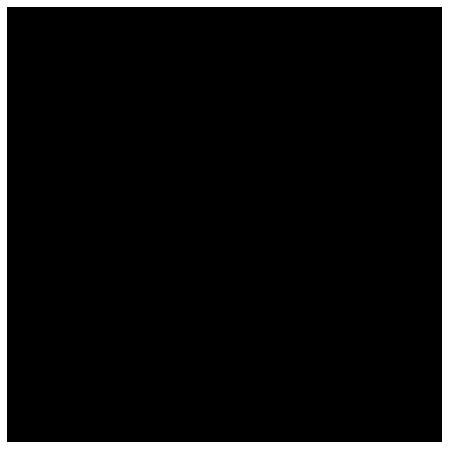

Defense: Gaussian Noise
Prediction of original sample: stingray - confidence 8.21
Prediction of adversarial sample: stingray - confidence 5.54


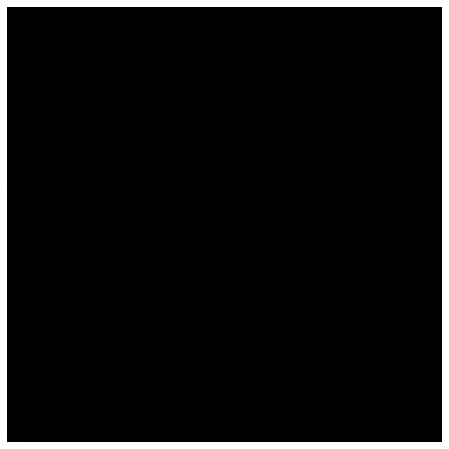

Defense: Total Variance Minimization
Prediction of original sample: tiger shark, Galeocerdo cuvieri - confidence 6.56
Prediction of adversarial sample: hen - confidence 8.11


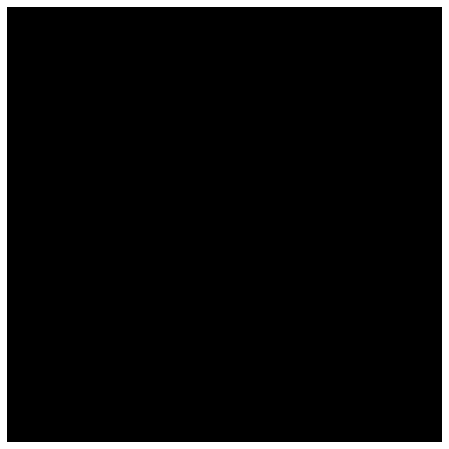

Defense: Class Labels Compression 
Prediction of original sample: tiger shark, Galeocerdo cuvieri - confidence 6.70
Prediction of adversarial sample: tiger shark, Galeocerdo cuvieri - confidence 6.70


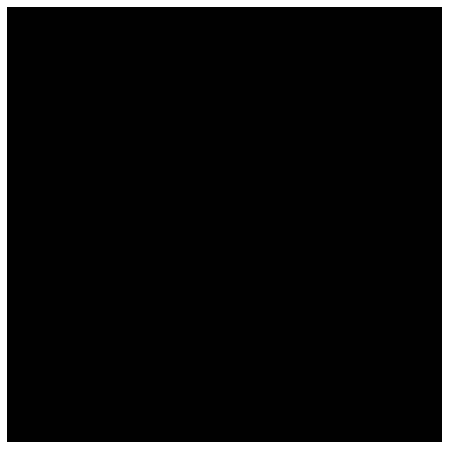

In [3]:
!pip install git+https://github.com/nottombrown/imagenet_stubs

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name
from art.defences import JpegCompression
from art.defences import TotalVarMin
from art.defences import GaussianNoise
from art.defences import PixelDefend
from art.defences import ClassLabels

ss = JpegCompression(clip_values=(min_, max_))

x_art_def, _ = ss(x_test)
x_art_adv_def, _ = ss(x_test_adv_eps_5)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Defense: JPEG Compression ")
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()


ss = GaussianNoise()

x_art_def = ss(x_test)
x_art_adv_def = ss(x_test_adv_eps_5)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Defense: Gaussian Noise")
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()

ss = TotalVarMin(clip_values=(min_, max_))
x_art_def, _ = ss(x_test)
x_art_adv_def, _ = ss(x_test_adv_eps_5)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Defense: Total Variance Minimization")
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()


ss = ClassLabels()

x_art_def = ss(x_test)
x_art_adv_def = ss(x_test_adv_eps_5)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Defense: Class Labels Compression ")
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()